In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"angray11","key":"363f4bf43443f6eb86fdfc006e285152"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'kmader/skin-cancer-mnist-ham10000'

100% 5.20G/5.20G [03:56<00:00, 24.6MB/s]
100% 5.20G/5.20G [03:56<00:00, 23.6MB/s]


In [ ]:
! unzip /content/skin-cancer-mnist-ham10000.zip -d skin-cancer-mnist-ham10000

Streaming output truncated to the last 5000 lines.
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: skin-cancer-mnist-ham10000/ham1000

# Import packages

In [ ]:
# Import required moduls/libs for our model
import numpy as np          # linear algebra
import pandas as pd         # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.applications.regnet import RegNetY160, RegNetY320
from keras.applications.xception import Xception
from keras.applications.resnet_v2 import ResNet152V2, ResNet50V2
from keras.applications.densenet import DenseNet201
from keras.applications.efficientnet_v2 import EfficientNetV2S
from keras.applications.inception_v3 import InceptionV3

from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error as MSE, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.optimizers import Adam
import os

In [ ]:
# Reading the meta date of our data frame.
df_skin = pd.read_csv('/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
# Display the first 10 lines
df_skin.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
# Lesion/dis names are given in the description of the data set.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

# Lesion and it's abbriv.
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Maping the lesion type and ID to a dict.
df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

# Display the total found images.
print('Total number of images', len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

# Display the count of each lesion.
df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

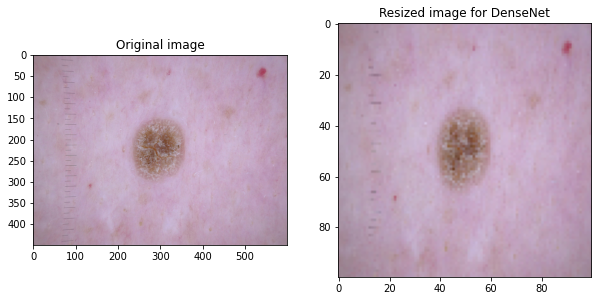

In [ ]:
# Reading a random image from our data set
fname_images = np.array(df_skin['image_id'])
file_to_read ='../content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_images[13])+'.jpg'

# Resizing the read image to 100x100
img = imread(file_to_read)
img2 = resize(img, (100, 100))

# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Resized image for DenseNet')
plt.show()

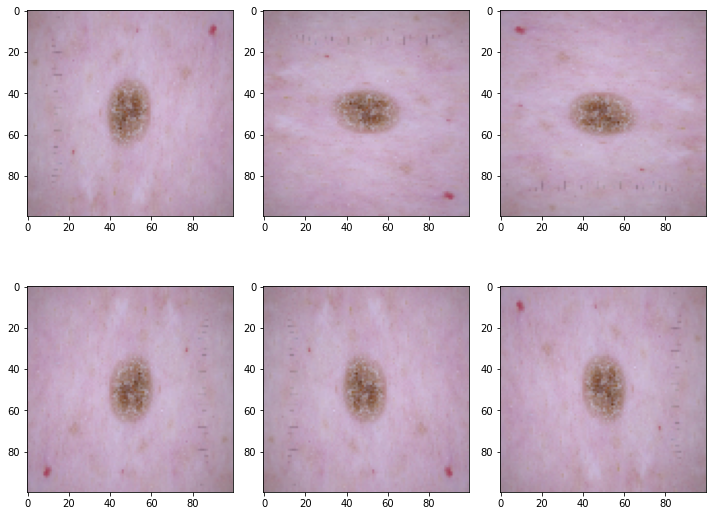

In [ ]:
def produce_new_img(img2: cv2) -> tuple:
    """
    function to reproduse a new manipulated (rotating of flipping the original one)
    image from the read one, To increase the dimension of the dataset, avoiding overfitting of a single class.

    Args:
        img2 (cv2): the read image from cv2 module.

    Returns:
        new_images (tuple): a tuple of the new manipulated images.
    """
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges

def show_example() -> None:
    """
    Display an image after manipulating it in produce_new_img() function
    """
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.show()

# Invoking our function :)
new_img = produce_new_img(img2)
# Display an example by invoking show_example func
show_example()

In [ ]:
x = []          # Hold resized images.
y = []          # Hold image lesion ID from the data set.

# Listing all files in the part_1, part_2 dirs
lista1 = os.listdir('../content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/')
lista2 = os.listdir('../content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/')

# [+] Handling images from part 1 directory
for i in range(len(lista1)):
    # [+] Features: reading and resize the photo.
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='../content/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + str(fname_image)  # resolve image name
    img = imread(file_to_read)                                  # read the image 
    img2 = resize(img,(100, 100))                               # resise our image
    x.append(img2)                                              # append the new image to the list x.
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
    if i % 100 == 0:
        print(i, 'images loaded')


# [+] Handling images from part 2 directory
for i in range(len(lista2)):

    # [+] Features: reading and resize the photo.
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='../content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img, (100, 100))
    x.append(img2)
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # [+] Add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    
    if i % 100 == 0: # [+] Inform the user with the number of loaded images each 100 img.
        print(len(lista1) + i,'images loaded')

0 images loaded
100 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1300 images loaded
1500 images loaded
1700 images loaded
1800 images loaded
1900 images loaded
2000 images loaded
2100 images loaded
2200 images loaded
2300 images loaded
2400 images loaded
2900 images loaded
3000 images loaded
3300 images loaded
3400 images loaded
3500 images loaded
3600 images loaded
3700 images loaded
4000 images loaded
4100 images loaded
4200 images loaded
4500 images loaded
4700 images loaded
4800 images loaded
4900 images loaded
5000 images loaded
5100 images loaded
5300 images loaded
5400 images loaded
5700 images loaded
5800 images loaded
5900 images loaded
6100 images loaded
6200 images loaded
6500 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7100 images loaded
7200 images loaded
7300 images loaded
7600

In [ ]:
x = np.array(x)
y = np.array(y)

# convert y (targets) array as required by softmax activation function
y_train = to_categorical(y, num_classes = 7)

In [ ]:
# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(x,                  # Images array.
                                                    y_train,            # The training set.
                                                    test_size = 0.20,   # Split data set into 20/80.
                                                    random_state = 50,  # Shuffling number to random the set.
                                                    stratify = y)       # Mix training and test sets.
# [+] Display the count of train/test data set.
print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (21252, 100, 100, 3)
Test dataset shape (5313, 100, 100, 3)


In [ ]:
def plot_history(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

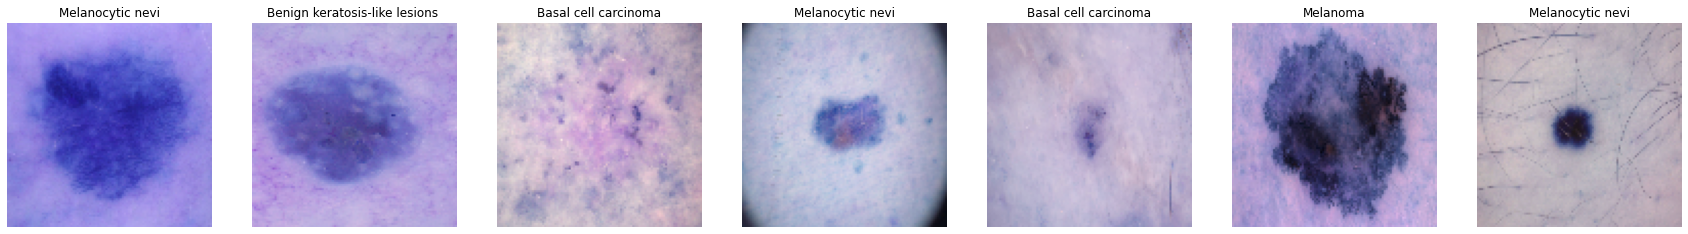

In [ ]:
def show_neg_figuers() -> None:
    """ Display negative figuers of the classes. """
    # Figure, Axes
    _, ax = plt.subplots(1, 7, figsize = (30, 30))
    for i in range(7):
        ax[i].set_axis_off()                                    # set the image to negative.
        ax[i].imshow(X_train[i])                                # Display the img.
        ax[i].set_title(lesion_names[np.argmax(y_train[i])])    # Set image title.

show_neg_figuers()

In [ ]:
def est_class_weights(dis_id: np.array) -> dict:
    """Estimate class weights for unbalanced datasets.

    Args:
        dis_id (np.array): numpy array of dis IDs

    Returns:
        dict: Estimated class weights for for unbalanced datasets.
    """
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(df_skin['lesion_ID'])
new_class_weights = est_class_weights(y_id)
print('The problem is unbalanced. We need to provide class-weights')
print(new_class_weights)

The problem is unbalanced. We need to provide class-weights
None


In [ ]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [ ]:
model_vgg = Sequential()

model_vgg.add(VGG19(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_vgg.add(Flatten())
model_vgg.add(Dense(7, activation = 'softmax'))

model_vgg.summary()



80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 20,027,975
Trainable params: 20,027,975
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_regnet160 = Sequential()

model_regnet160.add(RegNetY160(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_regnet160.add(Flatten())
model_regnet160.add(Dense(7, activation = 'softmax'))

model_regnet160.summary()

323550176/323550176 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 regnety160 (Functional)     (None, 3024)              80687956  
                                                                 
 flatten_1 (Flatten)         (None, 3024)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 21175     
                                                                 
Total params: 80,709,131
Trainable params: 80,586,315
Non-trainable params: 122,816
_________________________________________________________________


In [ ]:
model_regnet320 = Sequential()

model_regnet320.add(RegNetY320(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_regnet320.add(Flatten())
model_regnet320.add(Dense(7, activation = 'softmax'))

model_regnet320.summary()

566841248/566841248 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 regnety320 (Functional)     (None, 3712)              141492058 
                                                                 
 flatten_2 (Flatten)         (None, 3712)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 25991     
                                                                 
Total params: 141,518,049
Trainable params: 141,359,761
Non-trainable params: 158,288
_________________________________________________________________


In [ ]:
model_xcept = Sequential()

model_xcept.add(Xception(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_xcept.add(Flatten())
model_xcept.add(Dense(7, activation = 'softmax'))

model_xcept.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model_resnet50 = Sequential()

model_resnet50.add(ResNet50V2(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(7, activation = 'softmax'))

model_resnet50.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,579,143
Trainable params: 23,533,703
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
model_resnet152 = Sequential()

model_resnet152.add(ResNet152V2(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_resnet152.add(Flatten())
model_resnet152.add(Dense(7, activation = 'softmax'))

model_resnet152.summary()

234545216/234545216 [==============================] - 11s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 58,345,991
Trainable params: 58,202,247
Non-trainable params: 143,744
_________________________________________________________________


In [ ]:
model_dense = Sequential()

model_dense.add(DenseNet201(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_dense.add(Flatten())
model_dense.add(Dense(7, activation = 'softmax'))

model_dense.summary()

74836368/74836368 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 7)                 13447     
                                                                 
Total params: 18,335,431
Trainable params: 18,106,375
Non-trainable params: 229,056
_________________________________________________________________


In [ ]:
model_eff = Sequential()

model_eff.add(EfficientNetV2S(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_eff.add(Flatten())
model_eff.add(Dense(7, activation = 'softmax'))

model_eff.summary()

82420632/82420632 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 20,340,327
Trainable params: 20,186,455
Non-trainable params: 153,872
_________________________________________________________________


In [ ]:
model_inc = Sequential()

model_inc.add(InceptionV3(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
model_inc.add(Flatten())
model_inc.add(Dense(7, activation = 'softmax'))

model_inc.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 21,817,127
Trainable params: 21,782,695
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
#model_con = Sequential()

#model_con.add(ConvNeXtBase(include_top = False, input_shape = (100,100,3), weights = 'imagenet', pooling = 'max'))
#model_con.add(Flatten())
#model_con.add(Dense(7, activation = 'softmax'))

#model_con.summary()

In [ ]:
model_cust = Sequential()
        
# [+] 1st convolutional layer
model_cust.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model_cust.add(BatchNormalization())
model_cust.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 2nd convolutional layer
model_cust.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model_cust.add(BatchNormalization())
model_cust.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 3rd convolutional layer
model_cust.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model_cust.add(BatchNormalization())

# [+] 4th convolutional layer
model_cust.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model_cust.add(BatchNormalization())

# [+] 5th convolutional layer
model_cust.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model_cust.add(BatchNormalization())
model_cust.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model_cust.add(Flatten())  # [+] Convert the Conv2D objects into one List.

# [+] 6th, Dense layer:
# From the Docs: 
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model_cust.add(Dense(4096, activation = 'relu'))
model_cust.add(Dropout(0.5))
              
# [+] 7th Dense layer
model_cust.add(Dense(4096, activation = 'relu'))
model_cust.add(Dropout(0.5))
              
# [+] 8th output layer
model_cust.add(Dense(7, activation = 'softmax'))


In [ ]:
##########################
### [+] Training phase ###
##########################

def mod_checkpoint_callback() -> None:
    """
    Saving our model
    
    Returns:
        None: Saving a checkpoint of the model.
    """
    trained_model = ModelCheckpoint(filepath = 'model.h5',  # result file name
                             save_weights_only = False,     # Save all training results/params.
                             monitor = 'val_accuracy',      # check our model accuracy if it's step forward.
                             mode = 'auto',                 # enable auto save.
                             save_best_only = True,         # if ac_new > ac_old
                             verbose = 1)
    return trained_model

# Montoring the training procces in each epoch.
early_stopping_monitor = EarlyStopping(patience = 10, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()

# Estimate the model data if it was big one.
optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)


datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
datagen.fit(X_train)

batch_size = 32     # samples in the network at once.
epochs = 100        # epochs number.

In [ ]:
import time


# VGG19

In [ ]:
#create callback
filepath = 'vgg.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]


model_vgg.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_vgg = model_vgg.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.1749 - accuracy: 0.5681
Epoch 1: val_accuracy improved from -inf to 0.56823, saving model to vgg.h5
665/665 [==============================] - 60s 74ms/step - loss: 1.1749 - accuracy: 0.5681 - val_loss: 1.2247 - val_accuracy: 0.5682
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.6814
Epoch 2: val_accuracy improved from 0.56823 to 0.67476, saving model to vgg.h5
665/665 [==============================] - 49s 74ms/step - loss: 0.8371 - accuracy: 0.6814 - val_loss: 0.8205 - val_accuracy: 0.6748
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.7222
Epoch 3: val_accuracy improved from 0.67476 to 0.72859, saving model to vgg.h5
665/665 [==============================] - 48s 73ms/step - loss: 0.7208 - accuracy: 0.7222 - val_loss: 0.7012 - val_accuracy: 0.7286
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 0.639

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  1741.7482039928436


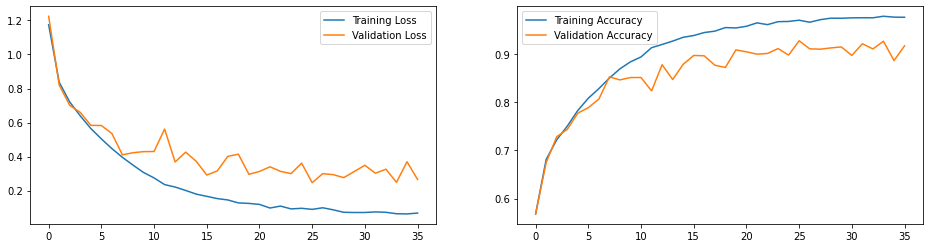

In [ ]:
plot_history(history_vgg)

In [ ]:
best_model_vgg = load_model('./vgg.h5')

# Compute predictions
y_pred_prob = np.around(best_model_vgg.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 1s 7ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.88      0.91      1341
           1       0.89      0.95      0.92      1336
           2       0.93      0.94      0.94      1319
           3       0.93      0.98      0.95       617
           4       0.94      0.87      0.90       392
           5       0.98      0.99      0.99       170
           6       1.00      0.93      0.97       138

    accuracy                           0.93      5313
   macro avg       0.95      0.94      0.94      5313
weighted avg       0.93      0.93      0.93      5313

Accuracy Score: 0.9281008846226237
Root Mean Square Error: 0.4778157845447321


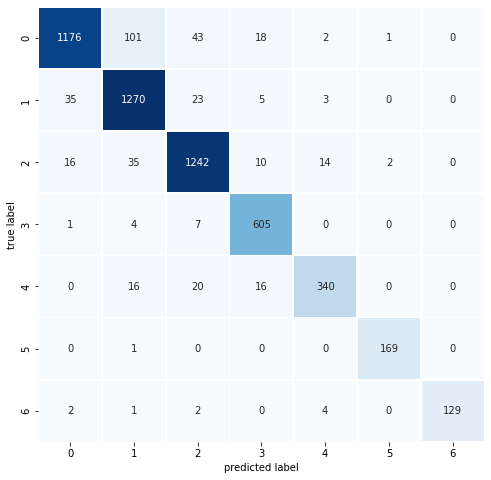

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_vgg.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 2s 9ms/step - loss: 0.2466 - accuracy: 0.9281
Accuracy: 92.81%


# RegNetY160

In [ ]:
#create callback
filepath = 'regnet160.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_regnet160.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

start = time.time()
history_regnet160 = model_regnet160.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.0010 - accuracy: 0.6189
Epoch 1: val_accuracy improved from -inf to 0.71542, saving model to regnet160.h5
665/665 [==============================] - 80s 101ms/step - loss: 1.0010 - accuracy: 0.6189 - val_loss: 0.7326 - val_accuracy: 0.7154
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.7625
Epoch 2: val_accuracy improved from 0.71542 to 0.80237, saving model to regnet160.h5
665/665 [==============================] - 60s 90ms/step - loss: 0.6232 - accuracy: 0.7625 - val_loss: 0.5211 - val_accuracy: 0.8024
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8229
Epoch 3: val_accuracy improved from 0.80237 to 0.82251, saving model to regnet160.h5
665/665 [==============================] - 60s 90ms/step - loss: 0.4663 - accuracy: 0.8229 - val_loss: 0.4650 - val_accuracy: 0.8225
Epoch 4/100
665/665 [==============================] - ET

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  2991.985012769699


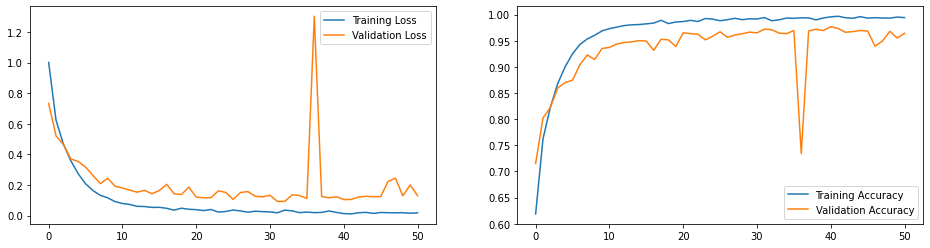

In [ ]:
plot_history(history_regnet160)

In [ ]:
best_model_regnet160 = load_model('./regnet160.h5')

# Compute predictions
y_pred_prob = np.around(best_model_regnet160.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 7s 28ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1341
           1       0.96      0.99      0.97      1336
           2       0.98      0.99      0.98      1319
           3       0.98      0.99      0.98       617
           4       1.00      0.96      0.98       392
           5       1.00      1.00      1.00       170
           6       0.99      0.97      0.98       138

    accuracy                           0.98      5313
   macro avg       0.98      0.98      0.98      5313
weighted avg       0.98      0.98      0.98      5313

Accuracy Score: 0.9768492377188029
Root Mean Square Error: 0.304925374942513


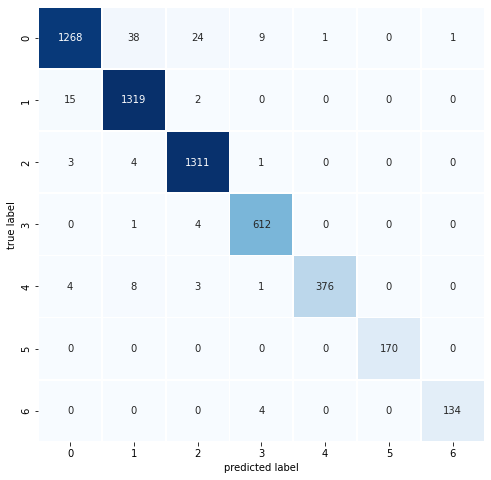

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_regnet160.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 6s 26ms/step - loss: 0.1045 - accuracy: 0.9768
Accuracy: 97.68%


# RegNetY320

In [ ]:
#create callback
filepath = 'regnet320.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_regnet320.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_regnet320 = model_regnet320.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.6473
Epoch 1: val_accuracy improved from -inf to 0.73480, saving model to regnet320.h5
665/665 [==============================] - 100s 130ms/step - loss: 0.9289 - accuracy: 0.6473 - val_loss: 0.6828 - val_accuracy: 0.7348
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.7813
Epoch 2: val_accuracy improved from 0.73480 to 0.81479, saving model to regnet320.h5
665/665 [==============================] - 81s 121ms/step - loss: 0.5790 - accuracy: 0.7813 - val_loss: 0.4891 - val_accuracy: 0.8148
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8424
Epoch 3: val_accuracy improved from 0.81479 to 0.82439, saving model to regnet320.h5
665/665 [==============================] - 81s 122ms/step - loss: 0.4156 - accuracy: 0.8424 - val_loss: 0.4656 - val_accuracy: 0.8244
Epoch 4/100
665/665 [==============================] -

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  3344.282075881958


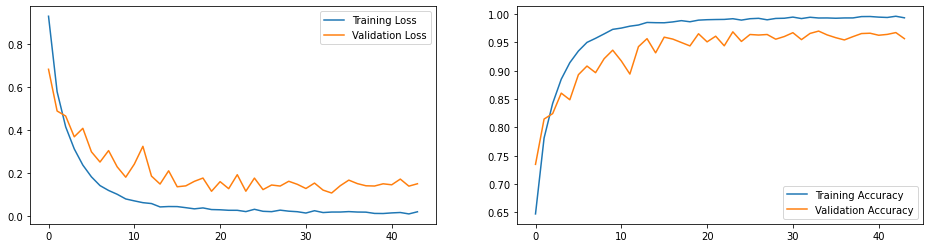

In [ ]:
plot_history(history_regnet320)

In [ ]:
best_model_regnet320 = load_model('./regnet320.h5')

# Compute predictions
y_pred_prob = np.around(best_model_regnet320.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 8s 34ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1341
           1       0.95      0.98      0.96      1336
           2       0.97      0.99      0.98      1319
           3       0.99      1.00      0.99       617
           4       0.99      0.97      0.98       392
           5       1.00      1.00      1.00       170
           6       0.95      1.00      0.98       138

    accuracy                           0.97      5313
   macro avg       0.98      0.98      0.98      5313
weighted avg       0.97      0.97      0.97      5313

Accuracy Score: 0.9700734048560136
Root Mean Square Error: 0.32436650097190584


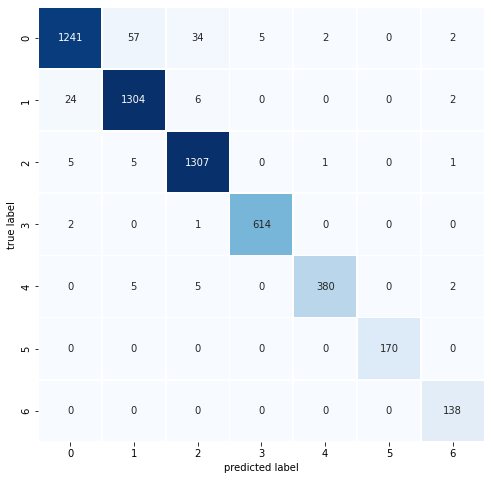

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_regnet320.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 7s 32ms/step - loss: 0.1085 - accuracy: 0.9701
Accuracy: 97.01%


# Xception

In [ ]:
#create callback
filepath = 'xcept.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_xcept.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_xcept = model_xcept.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.5943
Epoch 1: val_accuracy improved from -inf to 0.68078, saving model to xcept.h5
665/665 [==============================] - 66s 78ms/step - loss: 1.0540 - accuracy: 0.5943 - val_loss: 0.8537 - val_accuracy: 0.6808
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7651
Epoch 2: val_accuracy improved from 0.68078 to 0.80218, saving model to xcept.h5
665/665 [==============================] - 51s 76ms/step - loss: 0.6225 - accuracy: 0.7651 - val_loss: 0.5379 - val_accuracy: 0.8022
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.8368
Epoch 3: val_accuracy improved from 0.80218 to 0.82176, saving model to xcept.h5
665/665 [==============================] - 50s 75ms/step - loss: 0.4391 - accuracy: 0.8368 - val_loss: 0.4916 - val_accuracy: 0.8218
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss:

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  3007.710486650467


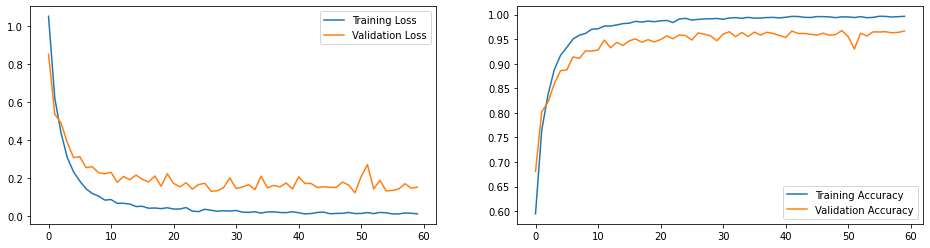

In [ ]:
plot_history(history_xcept)

In [ ]:
best_model_xcept = load_model('./xcept.h5')

# Compute predictions
y_pred_prob = np.around(best_model_xcept.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 2s 8ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.95      1341
           1       0.95      0.98      0.97      1336
           2       0.97      0.99      0.98      1319
           3       0.97      0.99      0.98       617
           4       0.99      0.92      0.95       392
           5       1.00      0.99      1.00       170
           6       0.96      0.99      0.97       138

    accuracy                           0.97      5313
   macro avg       0.97      0.97      0.97      5313
weighted avg       0.97      0.97      0.97      5313

Accuracy Score: 0.9674383587427066
Root Mean Square Error: 0.3629770043203139


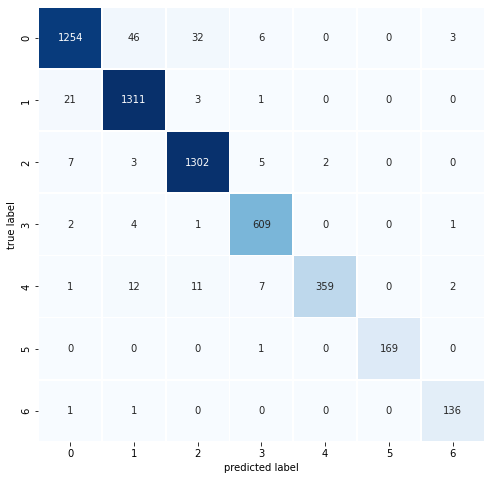

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_xcept.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 2s 9ms/step - loss: 0.1229 - accuracy: 0.9674
Accuracy: 96.74%


# ResNet50-V2

In [ ]:
#create callback
filepath = 'resnet50.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_resnet50.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_resnet50 = model_resnet50.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.1232 - accuracy: 0.6027
Epoch 1: val_accuracy improved from -inf to 0.68756, saving model to resnet50.h5
665/665 [==============================] - 57s 77ms/step - loss: 1.1232 - accuracy: 0.6027 - val_loss: 0.7890 - val_accuracy: 0.6876
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.7215 - accuracy: 0.7196
Epoch 2: val_accuracy improved from 0.68756 to 0.74402, saving model to resnet50.h5
665/665 [==============================] - 50s 75ms/step - loss: 0.7215 - accuracy: 0.7196 - val_loss: 0.6602 - val_accuracy: 0.7440
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7741
Epoch 3: val_accuracy did not improve from 0.74402
665/665 [==============================] - 48s 73ms/step - loss: 0.5928 - accuracy: 0.7741 - val_loss: 0.6727 - val_accuracy: 0.7414
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.81

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  1336.2979810237885


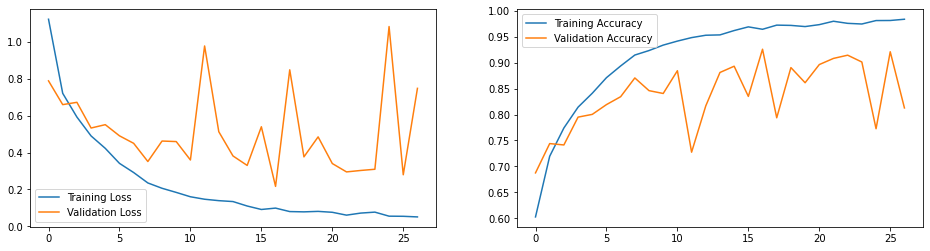

In [ ]:
plot_history(history_resnet50)

In [ ]:
best_model_resnet50 = load_model('./resnet50.h5')

# Compute predictions
y_pred_prob = np.around(best_model_resnet50.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 2s 9ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1341
           1       0.91      0.93      0.92      1336
           2       0.93      0.93      0.93      1319
           3       0.94      0.97      0.95       617
           4       0.88      0.95      0.91       392
           5       0.99      1.00      1.00       170
           6       0.98      0.91      0.94       138

    accuracy                           0.93      5313
   macro avg       0.94      0.94      0.94      5313
weighted avg       0.93      0.93      0.93      5313

Accuracy Score: 0.9258422736683606
Root Mean Square Error: 0.5304576150695561


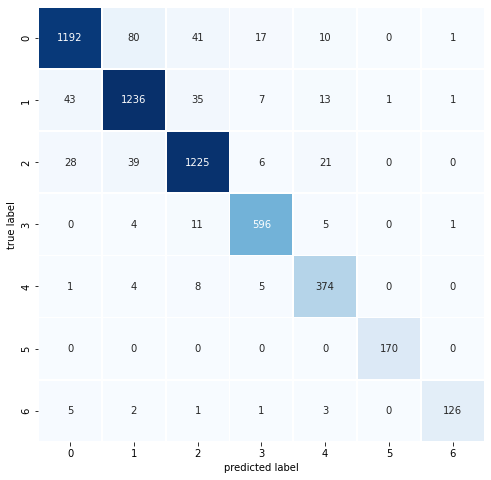

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_resnet50.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 3s 11ms/step - loss: 0.2168 - accuracy: 0.9258
Accuracy: 92.58%


# ResNet152-V2

In [ ]:
#create callback
filepath = 'resnet152-2.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = True,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_resnet152.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()

history_resnet152 = model_resnet152.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.8008
Epoch 1: val_accuracy improved from -inf to 0.71560, saving model to resnet152-2.h5
665/665 [==============================] - 81s 100ms/step - loss: 0.5198 - accuracy: 0.8008 - val_loss: 0.7694 - val_accuracy: 0.7156
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.4256 - accuracy: 0.8411
Epoch 2: val_accuracy improved from 0.71560 to 0.82533, saving model to resnet152-2.h5
665/665 [==============================] - 64s 96ms/step - loss: 0.4256 - accuracy: 0.8411 - val_loss: 0.4771 - val_accuracy: 0.8253
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.3510 - accuracy: 0.8697
Epoch 3: val_accuracy did not improve from 0.82533
665/665 [==============================] - 64s 96ms/step - loss: 0.3510 - accuracy: 0.8697 - val_loss: 0.5960 - val_accuracy: 0.7935
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 0.2827 - accurac

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  2993.5389878749847


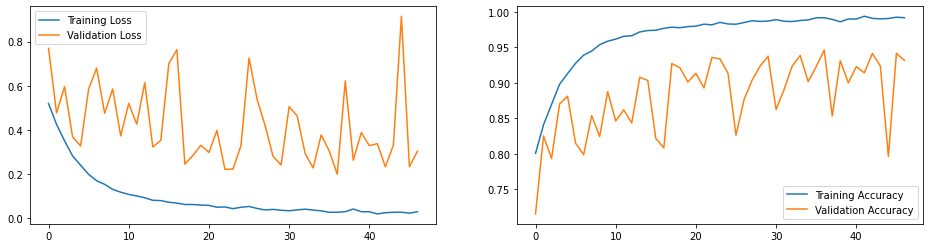

In [ ]:
plot_history(history_resnet152)

In [ ]:
#best_model_resnet152 = load_model('./resnet152-2.h5')

# Compute predictions
y_pred_prob = np.around(model_resnet152.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 8s 26ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1341
           1       0.91      0.95      0.93      1336
           2       0.88      0.99      0.93      1319
           3       0.93      0.95      0.94       617
           4       0.98      0.89      0.93       392
           5       0.99      0.98      0.99       170
           6       0.96      0.99      0.98       138

    accuracy                           0.93      5313
   macro avg       0.95      0.94      0.94      5313
weighted avg       0.94      0.93      0.93      5313

Accuracy Score: 0.9316770186335404
Root Mean Square Error: 0.46219795840893496


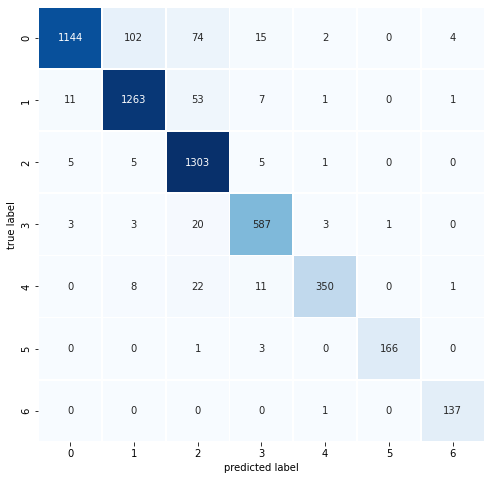

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_resnet152.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

# DenseNet

In [ ]:
#create callback
filepath = 'dense.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_dense.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_dense = model_dense.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 0.9080 - accuracy: 0.6759
Epoch 1: val_accuracy improved from -inf to 0.71880, saving model to dense.h5
665/665 [==============================] - 103s 110ms/step - loss: 0.9080 - accuracy: 0.6759 - val_loss: 0.8077 - val_accuracy: 0.7188
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.8281
Epoch 2: val_accuracy improved from 0.71880 to 0.85827, saving model to dense.h5
665/665 [==============================] - 69s 103ms/step - loss: 0.4636 - accuracy: 0.8281 - val_loss: 0.3941 - val_accuracy: 0.8583
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8914
Epoch 3: val_accuracy did not improve from 0.85827
665/665 [==============================] - 67s 101ms/step - loss: 0.2879 - accuracy: 0.8914 - val_loss: 0.6274 - val_accuracy: 0.7922
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9254

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  2608.762346506119


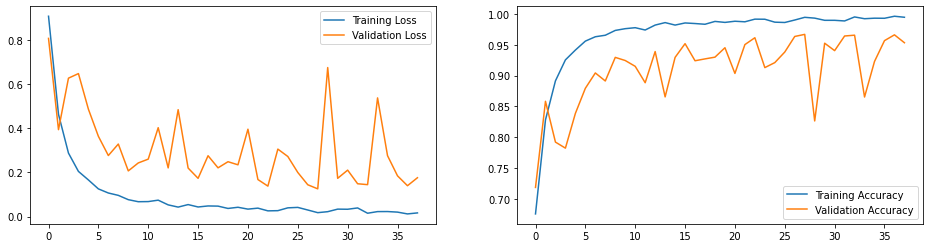

In [ ]:
plot_history(history_dense)

In [ ]:
best_model_dense = load_model('./dense.h5')

# Compute predictions
y_pred_prob = np.around(best_model_dense.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 7s 27ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1341
           1       0.95      0.97      0.96      1336
           2       0.97      0.99      0.98      1319
           3       0.98      0.98      0.98       617
           4       0.97      0.98      0.98       392
           5       1.00      1.00      1.00       170
           6       0.98      0.99      0.99       138

    accuracy                           0.97      5313
   macro avg       0.97      0.98      0.98      5313
weighted avg       0.97      0.97      0.97      5313

Accuracy Score: 0.9666854884246189
Root Mean Square Error: 0.35325381133547284


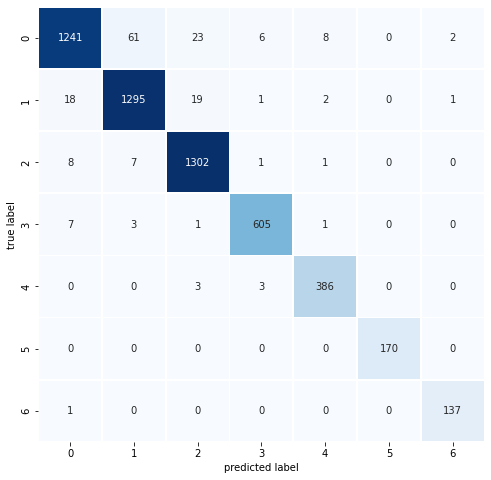

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_dense.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 8s 27ms/step - loss: 0.1258 - accuracy: 0.9667
Accuracy: 96.67%


# EfficientNet V2 S

In [ ]:
#create callback
filepath = 'eff.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_eff.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_eff = model_eff.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.0236 - accuracy: 0.6150
Epoch 1: val_accuracy improved from -inf to 0.72671, saving model to eff.h5
665/665 [==============================] - 88s 102ms/step - loss: 1.0236 - accuracy: 0.6150 - val_loss: 0.7157 - val_accuracy: 0.7267
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.7685
Epoch 2: val_accuracy improved from 0.72671 to 0.79522, saving model to eff.h5
665/665 [==============================] - 65s 98ms/step - loss: 0.6154 - accuracy: 0.7685 - val_loss: 0.5447 - val_accuracy: 0.7952
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.8272
Epoch 3: val_accuracy improved from 0.79522 to 0.84397, saving model to eff.h5
665/665 [==============================] - 65s 98ms/step - loss: 0.4505 - accuracy: 0.8272 - val_loss: 0.4112 - val_accuracy: 0.8440
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 0.33

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  2392.507588148117


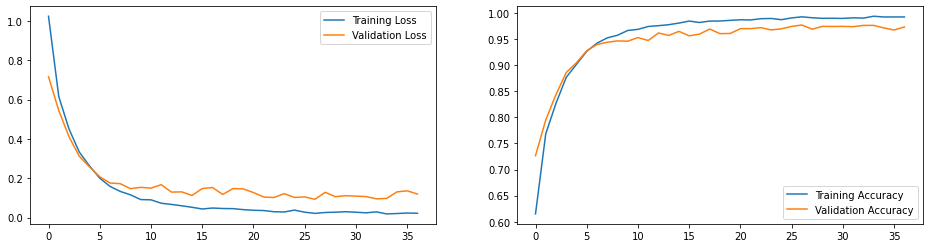

In [ ]:
plot_history(history_eff)

In [ ]:
best_model_eff = load_model('./eff.h5')

# Compute predictions
y_pred_prob = np.around(best_model_eff.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 6s 22ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1341
           1       0.96      0.99      0.98      1336
           2       0.98      0.99      0.98      1319
           3       0.98      0.98      0.98       617
           4       0.99      0.99      0.99       392
           5       1.00      1.00      1.00       170
           6       0.97      1.00      0.99       138

    accuracy                           0.98      5313
   macro avg       0.98      0.99      0.98      5313
weighted avg       0.98      0.98      0.98      5313

Accuracy Score: 0.9772256728778468
Root Mean Square Error: 0.2874500259351634


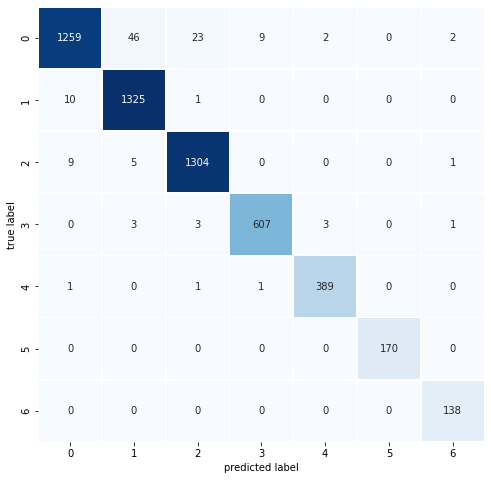

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_eff.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 7s 23ms/step - loss: 0.0934 - accuracy: 0.9772
Accuracy: 97.72%


# Inception V3

In [ ]:
#create callback
filepath = 'inc.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_inc.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_inc = model_inc.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.0245 - accuracy: 0.6114
Epoch 1: val_accuracy improved from -inf to 0.63806, saving model to inc.h5
665/665 [==============================] - 62s 81ms/step - loss: 1.0245 - accuracy: 0.6114 - val_loss: 0.9809 - val_accuracy: 0.6381
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.7376
Epoch 2: val_accuracy improved from 0.63806 to 0.73480, saving model to inc.h5
665/665 [==============================] - 53s 79ms/step - loss: 0.6998 - accuracy: 0.7376 - val_loss: 0.7234 - val_accuracy: 0.7348
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7960
Epoch 3: val_accuracy improved from 0.73480 to 0.77696, saving model to inc.h5
665/665 [==============================] - 53s 79ms/step - loss: 0.5427 - accuracy: 0.7960 - val_loss: 0.5940 - val_accuracy: 0.7770
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 0.449

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  2729.2702193260193


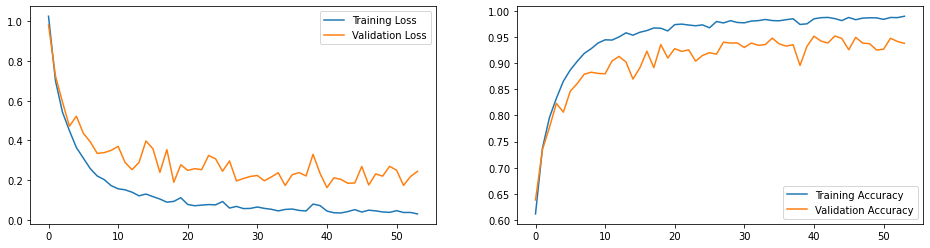

In [ ]:
plot_history(history_inc)

In [ ]:
best_model_inc = load_model('./inc.h5')

# Compute predictions
y_pred_prob = np.around(best_model_inc.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 3s 13ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1341
           1       0.92      0.97      0.94      1336
           2       0.95      0.97      0.96      1319
           3       0.99      0.95      0.97       617
           4       0.98      0.92      0.95       392
           5       0.99      0.99      0.99       170
           6       0.98      0.99      0.99       138

    accuracy                           0.95      5313
   macro avg       0.97      0.96      0.96      5313
weighted avg       0.95      0.95      0.95      5313

Accuracy Score: 0.9523809523809523
Root Mean Square Error: 0.39856697946080116


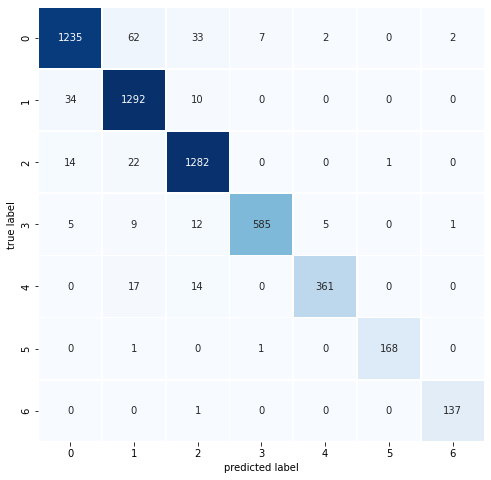

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_inc.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 4s 14ms/step - loss: 0.1847 - accuracy: 0.9524
Accuracy: 95.24%


# Custom model

In [ ]:
#create callback
filepath = 'cust.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             save_weights_only = False,
                             verbose=1, 
                             save_best_only=True,
                             mode='auto')
callbacks = [checkpoint]

model_cust.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start = time.time()
history_cust = model_cust.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, callbacks],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )
end = time.time()

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.4268 - accuracy: 0.4895
Epoch 1: val_accuracy improved from -inf to 0.33936, saving model to cust.h5
665/665 [==============================] - 50s 74ms/step - loss: 1.4268 - accuracy: 0.4895 - val_loss: 2.4754 - val_accuracy: 0.3394
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 1.0696 - accuracy: 0.5836
Epoch 2: val_accuracy improved from 0.33936 to 0.56296, saving model to cust.h5
665/665 [==============================] - 49s 74ms/step - loss: 1.0696 - accuracy: 0.5836 - val_loss: 1.0966 - val_accuracy: 0.5630
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.6144
Epoch 3: val_accuracy improved from 0.56296 to 0.60757, saving model to cust.h5
665/665 [==============================] - 50s 75ms/step - loss: 0.9845 - accuracy: 0.6144 - val_loss: 1.0049 - val_accuracy: 0.6076
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 0.

In [ ]:
print("Run time [s]: ",end-start)

Run time [s]:  1831.0325500965118


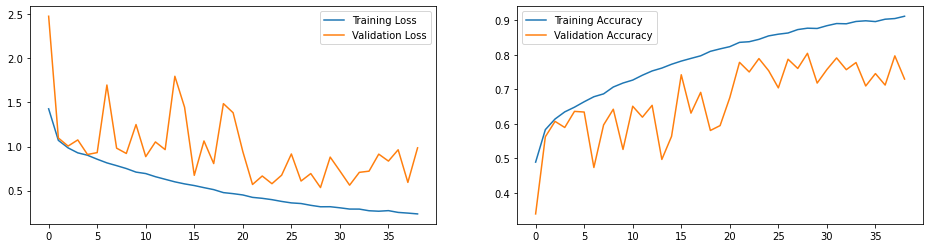

In [ ]:
plot_history(history_cust)

In [ ]:
best_model_cust = load_model('./cust.h5')

# Compute predictions
y_pred_prob = np.around(best_model_cust.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)
print_validation_report(y_test2, y_pred)

167/167 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1341
           1       0.77      0.85      0.81      1336
           2       0.80      0.75      0.78      1319
           3       0.78      0.87      0.82       617
           4       0.77      0.67      0.72       392
           5       0.97      0.88      0.93       170
           6       0.91      0.68      0.78       138

    accuracy                           0.80      5313
   macro avg       0.84      0.79      0.81      5313
weighted avg       0.81      0.80      0.80      5313

Accuracy Score: 0.8048183700357613
Root Mean Square Error: 0.8434823356732999


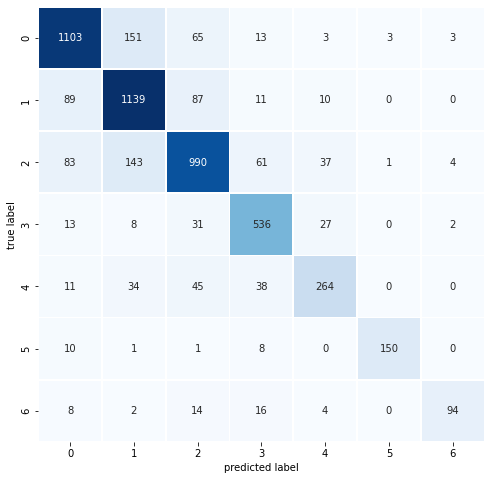

In [ ]:
plot_confusion_matrix(y_test2,y_pred)

In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model_cust.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 1s 4ms/step - loss: 0.5351 - accuracy: 0.8048
Accuracy: 80.48%
